## Single cell RNA-Seq analysis of in vitro induced murine KRAS<sup>G12D</sup> organoids
- Murine AT2 cells were collected using FACS then induced in vitro using Ad5-CMV-empty (control) or Ad5-CMV-Cre (transformed).
- Transcriptome were analysis using single cell RNA Seq (10X Genomics).

### Environment

In [1]:
# import packages 

import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/home/alm72/.conda/envs/KYorg_env/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


### Data pre-processing

In [ ]:
# CellRanger output
filenames = ['KY_empty_filtered_feature_bc_matrix.h5','KY_cre_filtered_feature_bc_matrix.h5']
adatas = [sc.read_10x_h5(filename) for filename in filenames]
adata.var_names_make_unique()  
adata = adatas[0].concatenate(adatas[1:],batch_categories=['KY-Empty','KY-Cre']) 

# make sure gene names are unique
adata.var_names_make_unique()

... storing 'feature_types' as categorical
... storing 'genome' as categorical


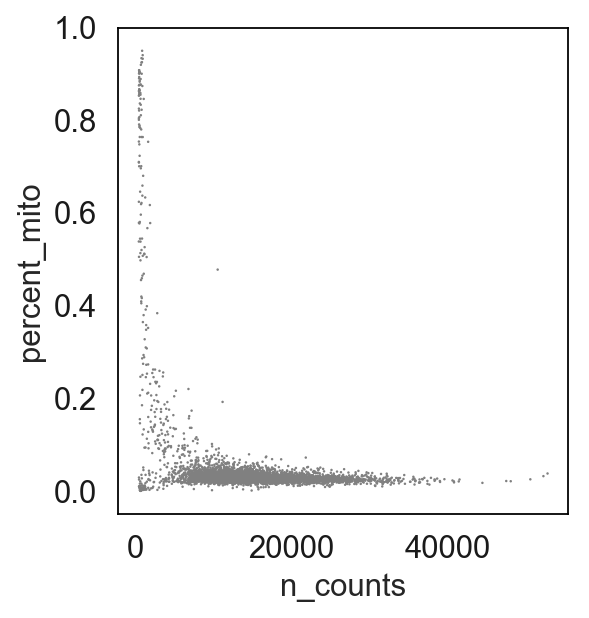

filtered out 11955 genes that are detectedin less than 3 cells


Trying to set attribute `.var` of view, making a copy.


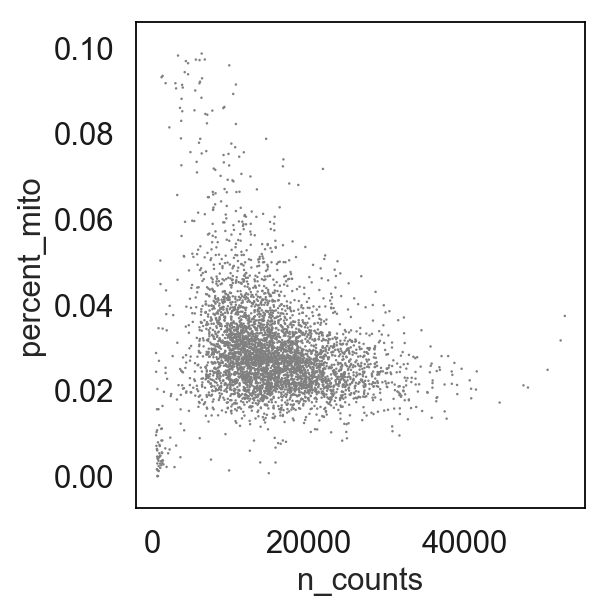

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:05)


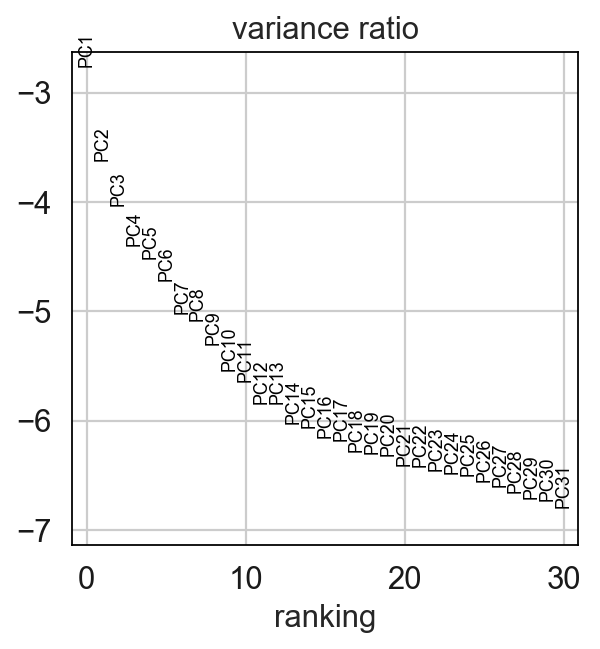

In [254]:
# compute %mito and remove cells with >10%
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# plot mitochondrial content (y-axis) against read count before and after filtering cells with > 10% mitochondrial gene expression
# Cells wth >10% mito expression also has low read count indicating bad/dead cells rather than cells requiring more energy
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

adata = adata[adata.obs['percent_mito'] < 0.1, :]
sc.pp.filter_genes(adata, min_cells=3)

with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

# Normalize the data, save raw data, then use data diffusion tool (van Dijk et al 2018)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# No consensus about gene scaling so I did not scale the data. Read https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6582955/
# Not scaling argueably retains biological information
# I did not regress cell cycle either. A population of proliferative or non-proliferative cells in this context would be high interesting in my opinion

# save current data as adata.raw
adata.raw = adata

sc.tl.pca(adata, svd_solver='arpack') # svd_solver='arpack' is important for reproducibility
sc.pl.pca_variance_ratio(adata, log=True) # find significant pc's

### Data de-noising using MAGIC (van Dijk et al. 2018 Cell)

In [255]:
# Perform data diffusion. t=3 is sufficient to remove zero counts
sce.pp.magic(adata, name_list='all_genes', k=3, t=3, n_pca=30) # default settings

computing PHATE
    finished (0:00:04)


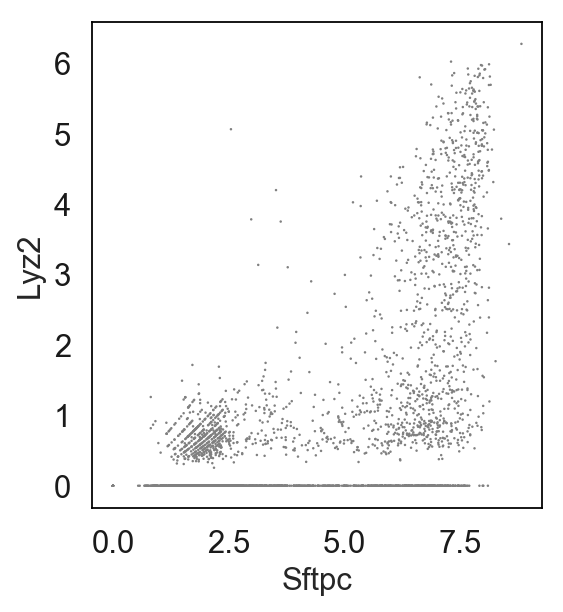

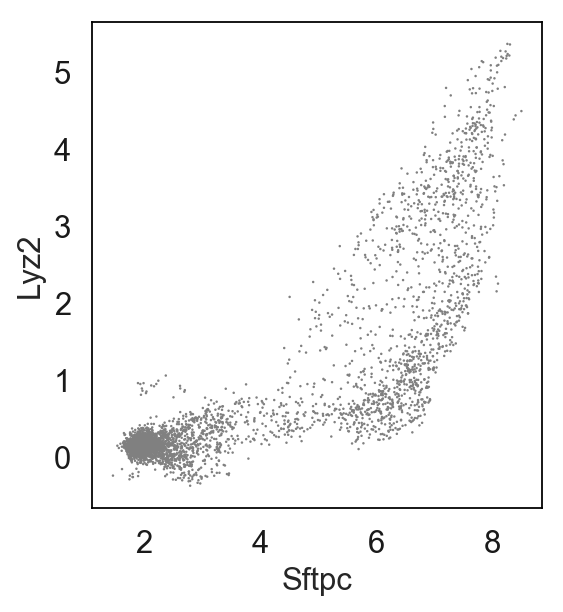

In [256]:
# Visualize

# Before MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=True)

# After MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=False)

In [257]:
#Intial filter
sc.pp.filter_cells(adata, min_genes=200)

# create nearest neighbors graph 
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)

# run louvain community detection algorithm
sc.tl.louvain(adata, resolution=0.01, key_added='louvain_r0.01')
sc.tl.louvain(adata, resolution=0.025, key_added='louvain_r0.025')
sc.tl.louvain(adata, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(adata, resolution=0.1, key_added='louvain_r0.1')
sc.tl.louvain(adata, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(adata, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(adata, resolution=0.4, key_added='louvain_r0.4')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

# Visualize different Louvain resolutions using UMAP
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


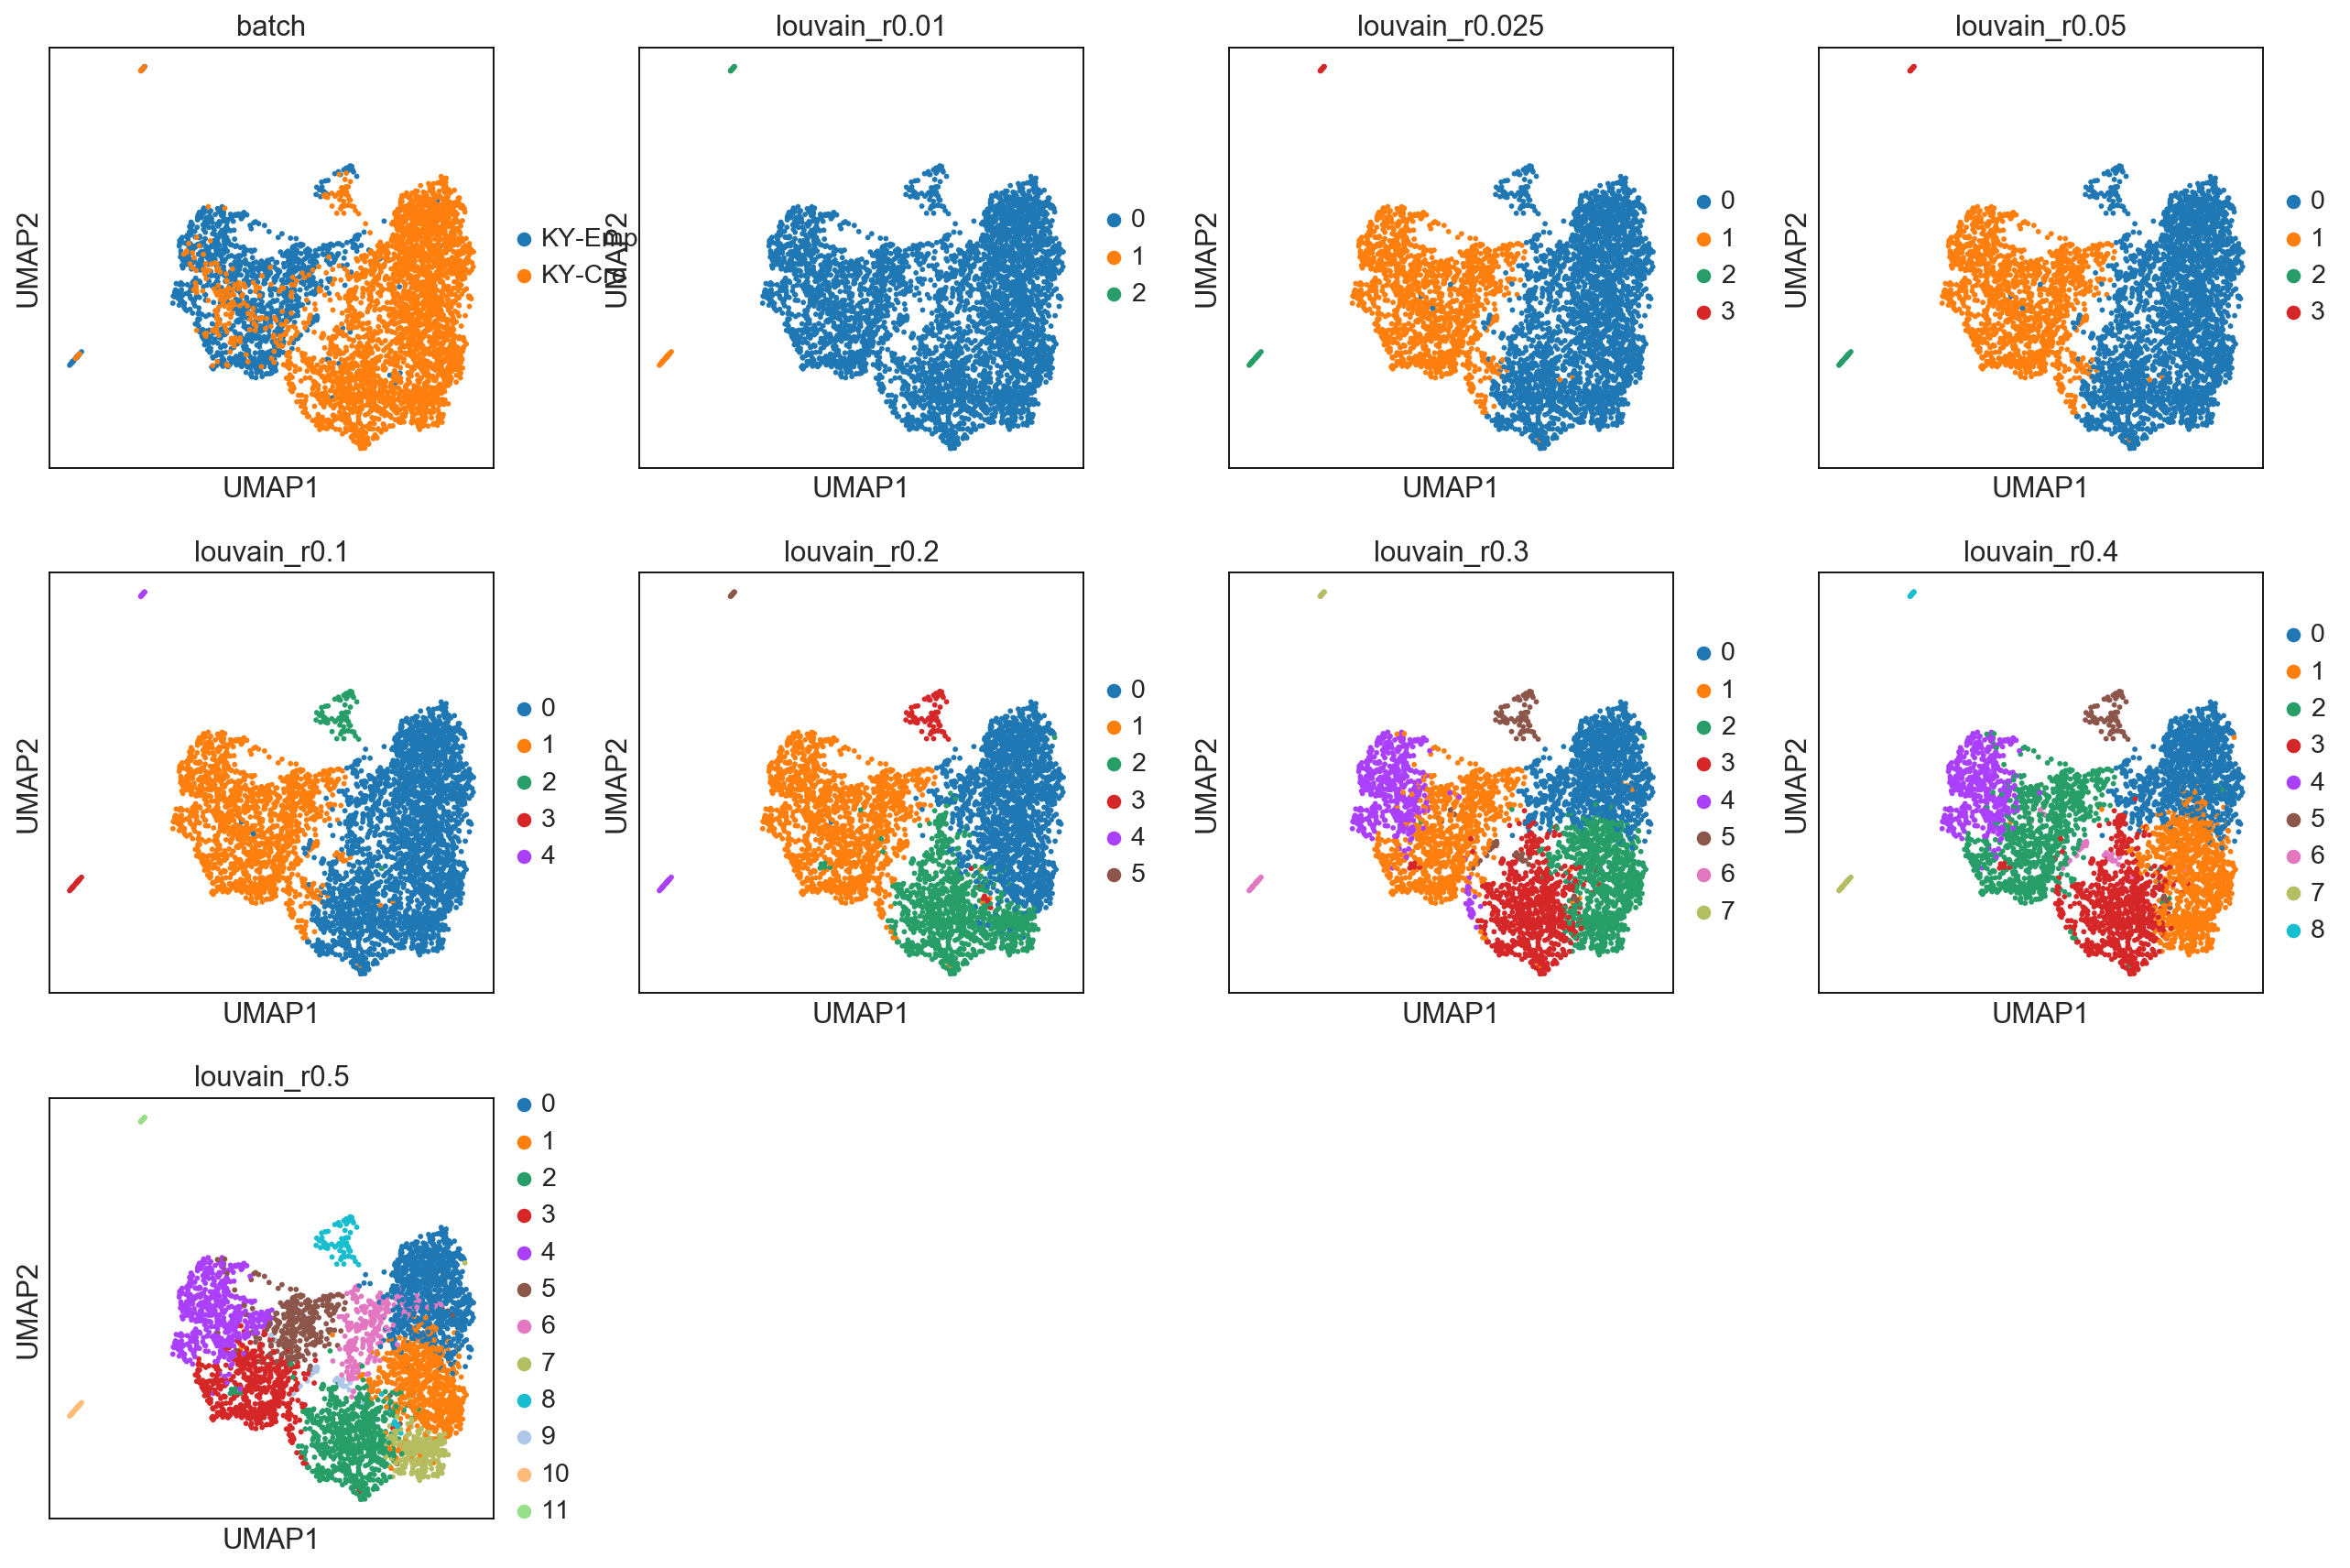

In [258]:
# Visualize differenti louvain resolutions
sc.pl.umap(adata, color=['batch','louvain_r0.01','louvain_r0.025','louvain_r0.05','louvain_r0.1','louvain_r0.2',
'louvain_r0.3','louvain_r0.4','louvain_r0.5'])

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


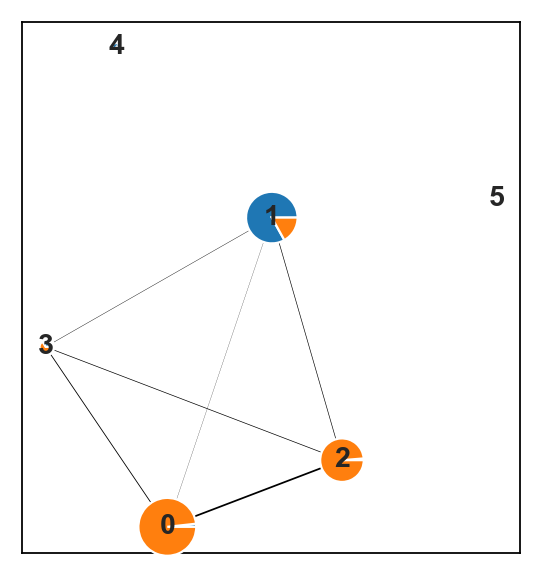

computing UMAP
    finished (0:00:03)


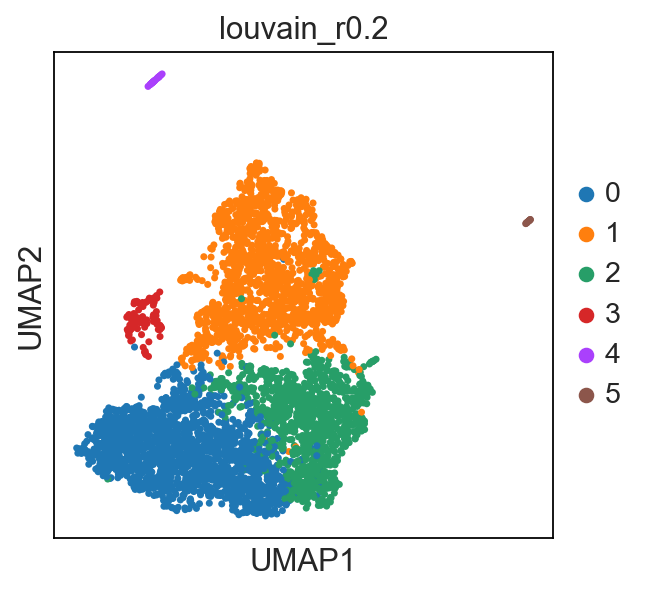

In [261]:
# Create a PAGA-initialized UMAP embedding (Wolf et al. 2018 Genome Biology). 

sc.tl.paga(adata, groups='louvain_r0.2')
sc.pl.paga(adata, plot=True, color=['batch'])

# sc.tl.umap(adata, init_pos='paga') was not working (August 7, 2019). Work-around -> https://github.com/theislab/scanpy/issues/769 

sc.tl.umap(adata, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))
sc.pl.umap(adata, frameon=True, color=['louvain_r0.2'], legend_loc='right margin', size=40) 


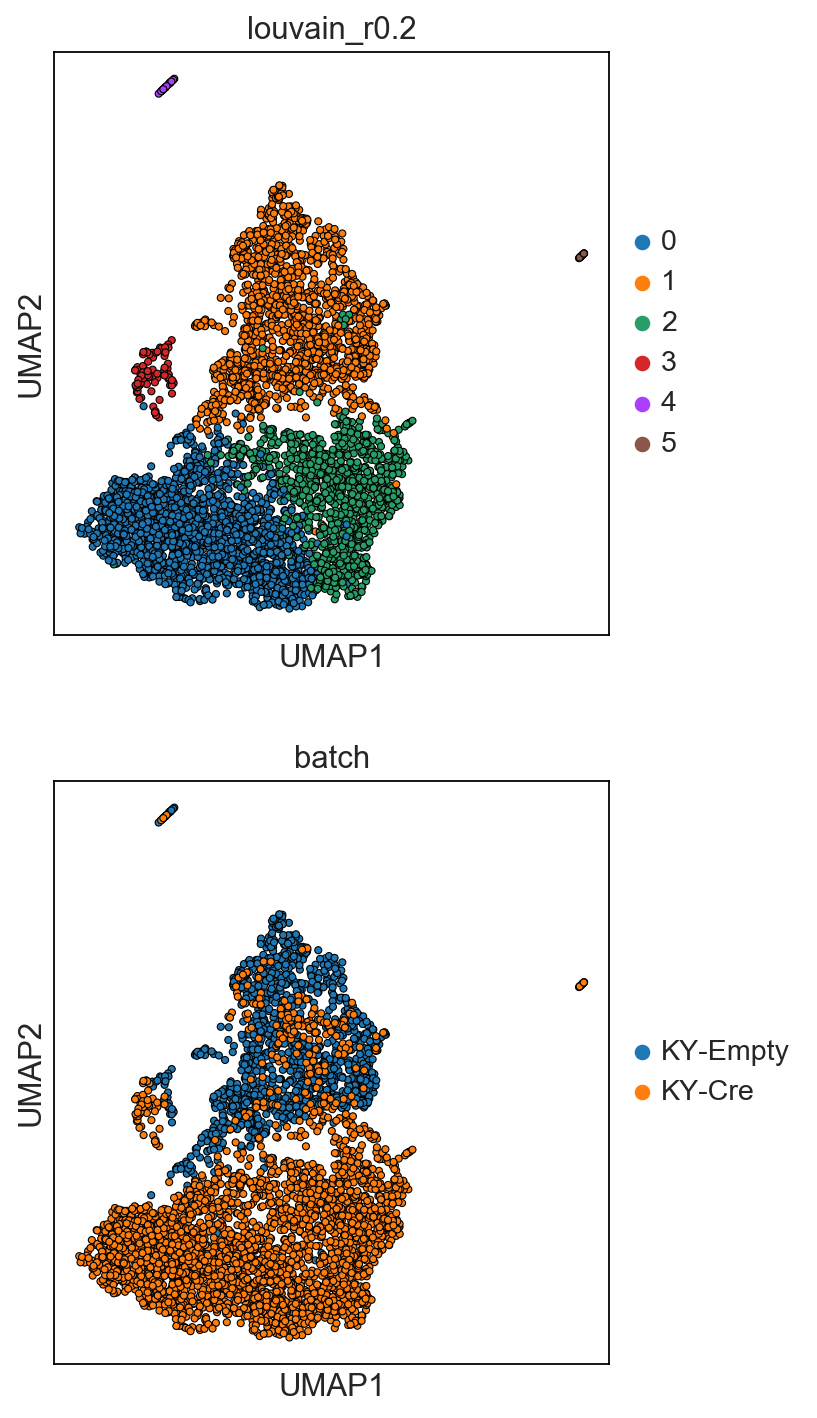

In [385]:
# Visualize the data
kwargs={'edgecolor':'black','linewidth':0.5}
sc.settings.set_figure_params(dpi=80)

rcParams['figure.figsize'] = 4,5
sc.pl.umap(adata, frameon=True, color=['louvain_r0.2','batch'], legend_loc='right margin', ncols=1,
size=40, show=True, **kwargs) # louvain

In [263]:
# counts cells per cluster then remove any clusters with less than 100 cells
adata.obs['louvain_r0.2'].value_counts()

0    1793
1    1425
2    1017
3      78
4      27
5      13
Name: louvain_r0.2, dtype: int64

In [271]:
# Remove small clusters and save subset data. Save adata too
adata_subset = adata[adata.obs['louvain_r0.2'].isin(['0','1','2'])]
adata_subset.write(subset_results_file) # save subset data
adata.write(results_file) # save adata

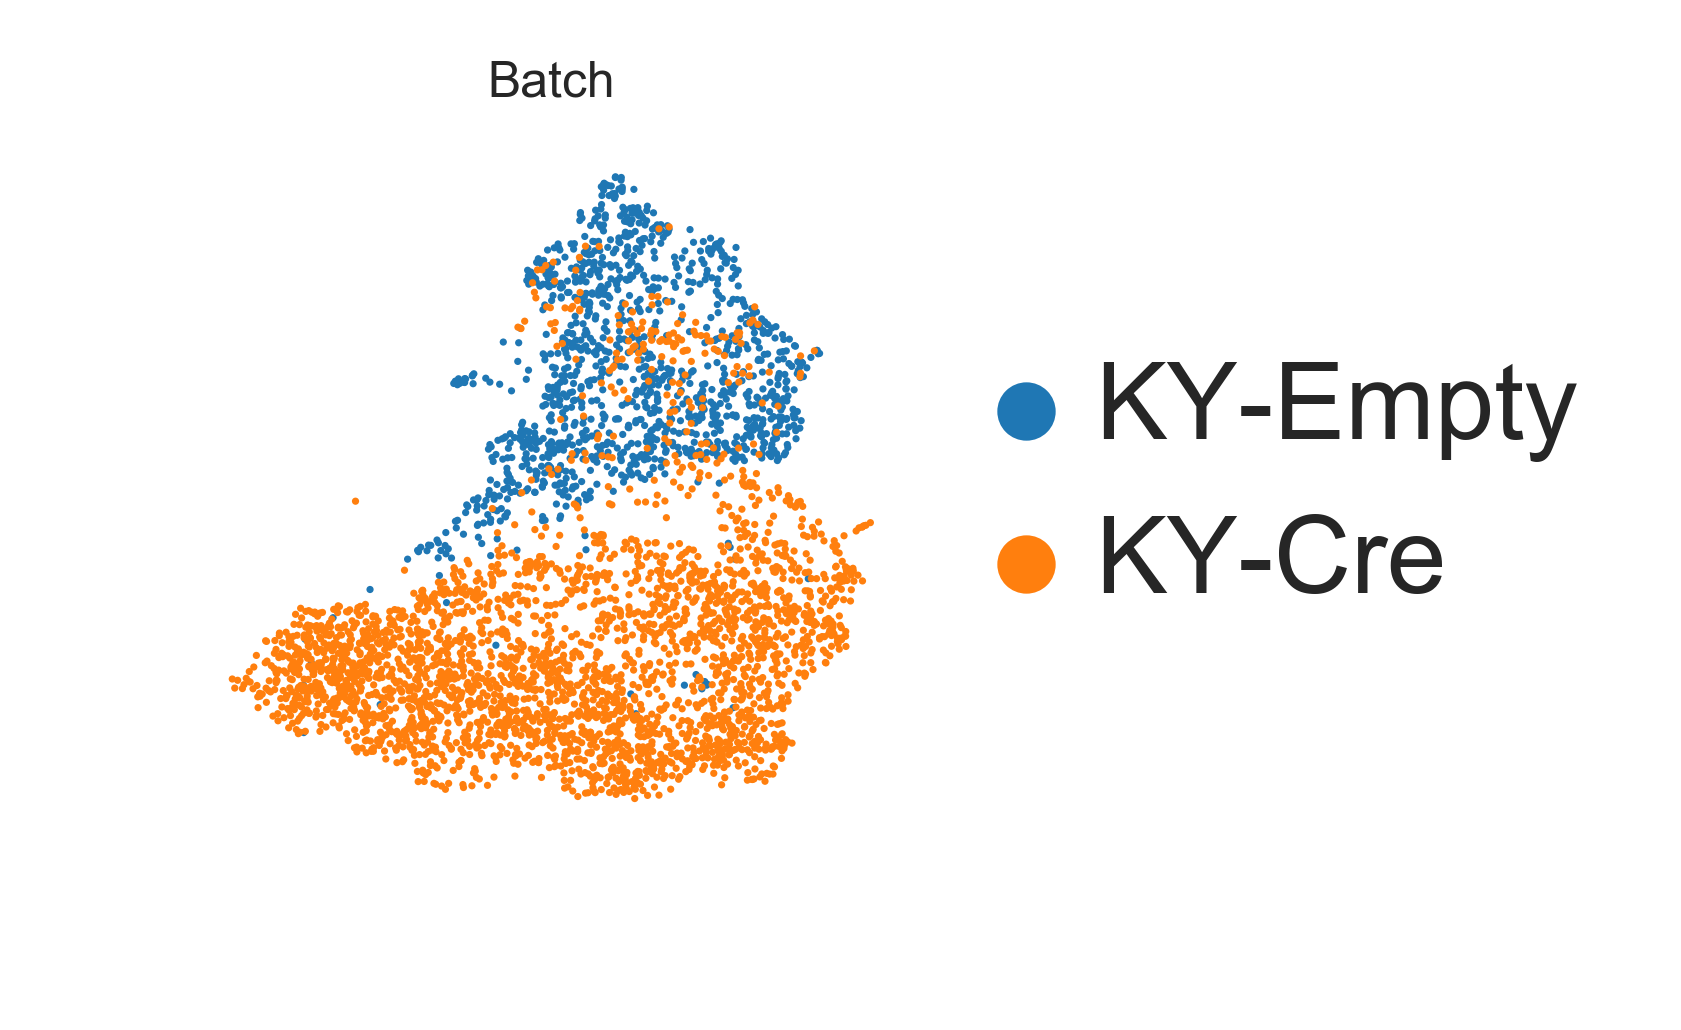

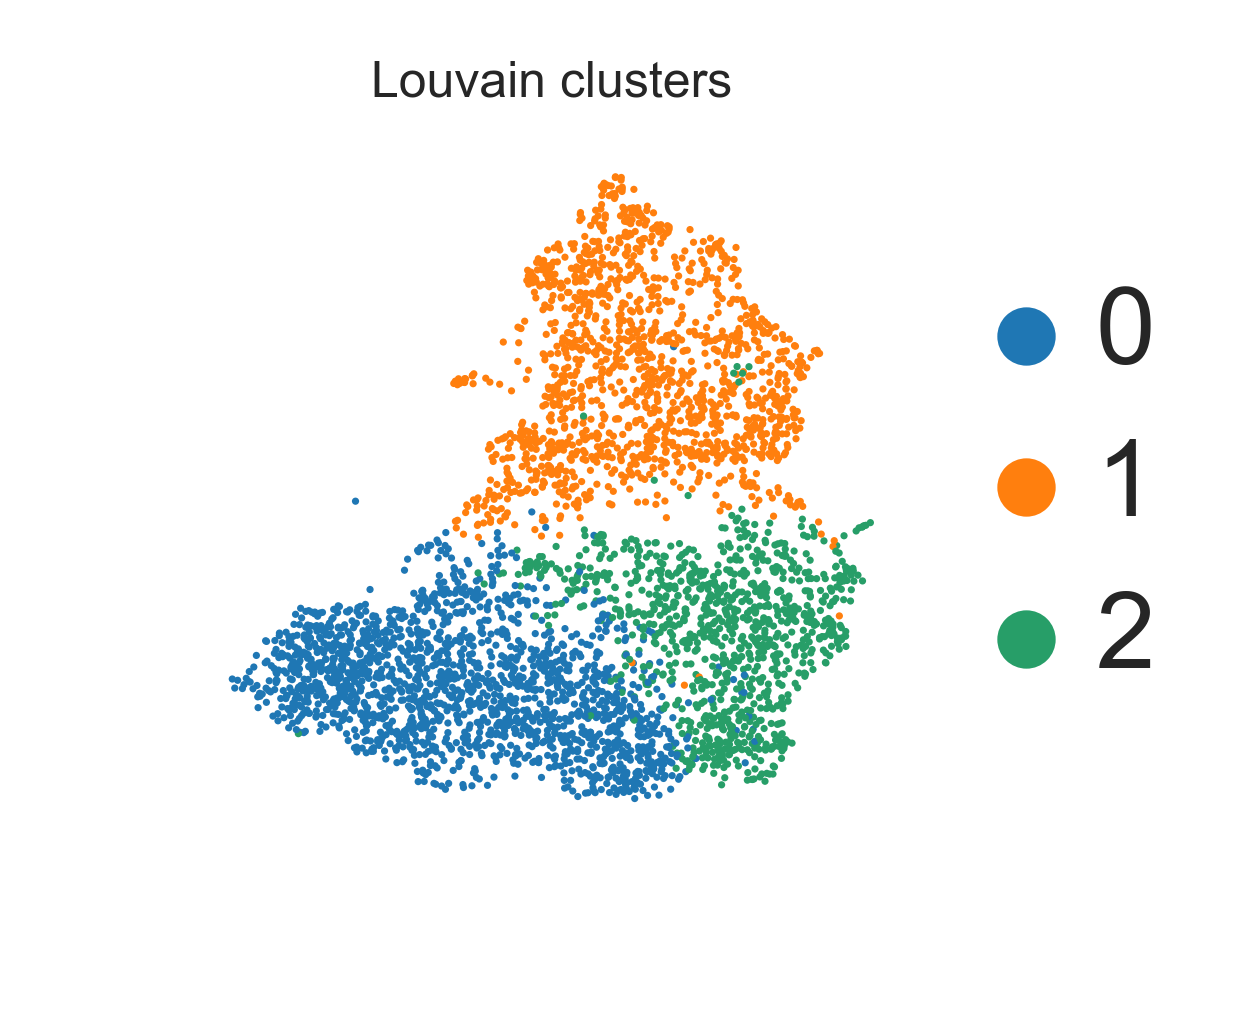

In [618]:
# Plot louvain and batch
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightcoral','red']) 
use_raw='False'
frameon=False
size=3 
figsize=1.5,1.5
fontsize=6
dpi=300
tick_size=5 # https://github.com/theislab/scanpy/issues/337

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['batch'],  frameon=frameon, vmin=0, vmax=1, 
use_raw=use_raw, size=size, show=False)
plt.title('Batch', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_batch.png', bbox_inches='tight', dpi=dpi)

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['louvain_r0.2'],  frameon=frameon, vmin=0, vmax=1, 
use_raw=use_raw, size=size, show=False)
plt.title('Louvain clusters', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_louvain.png', bbox_inches='tight', dpi=dpi)

In [272]:
# Create a dendrogram/ Default = pearsons correlation coefficient
sc.tl.dendrogram(adata_subset, n_pcs=30, groupby='louvain_r0.2')

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_louvain_r0.2']`


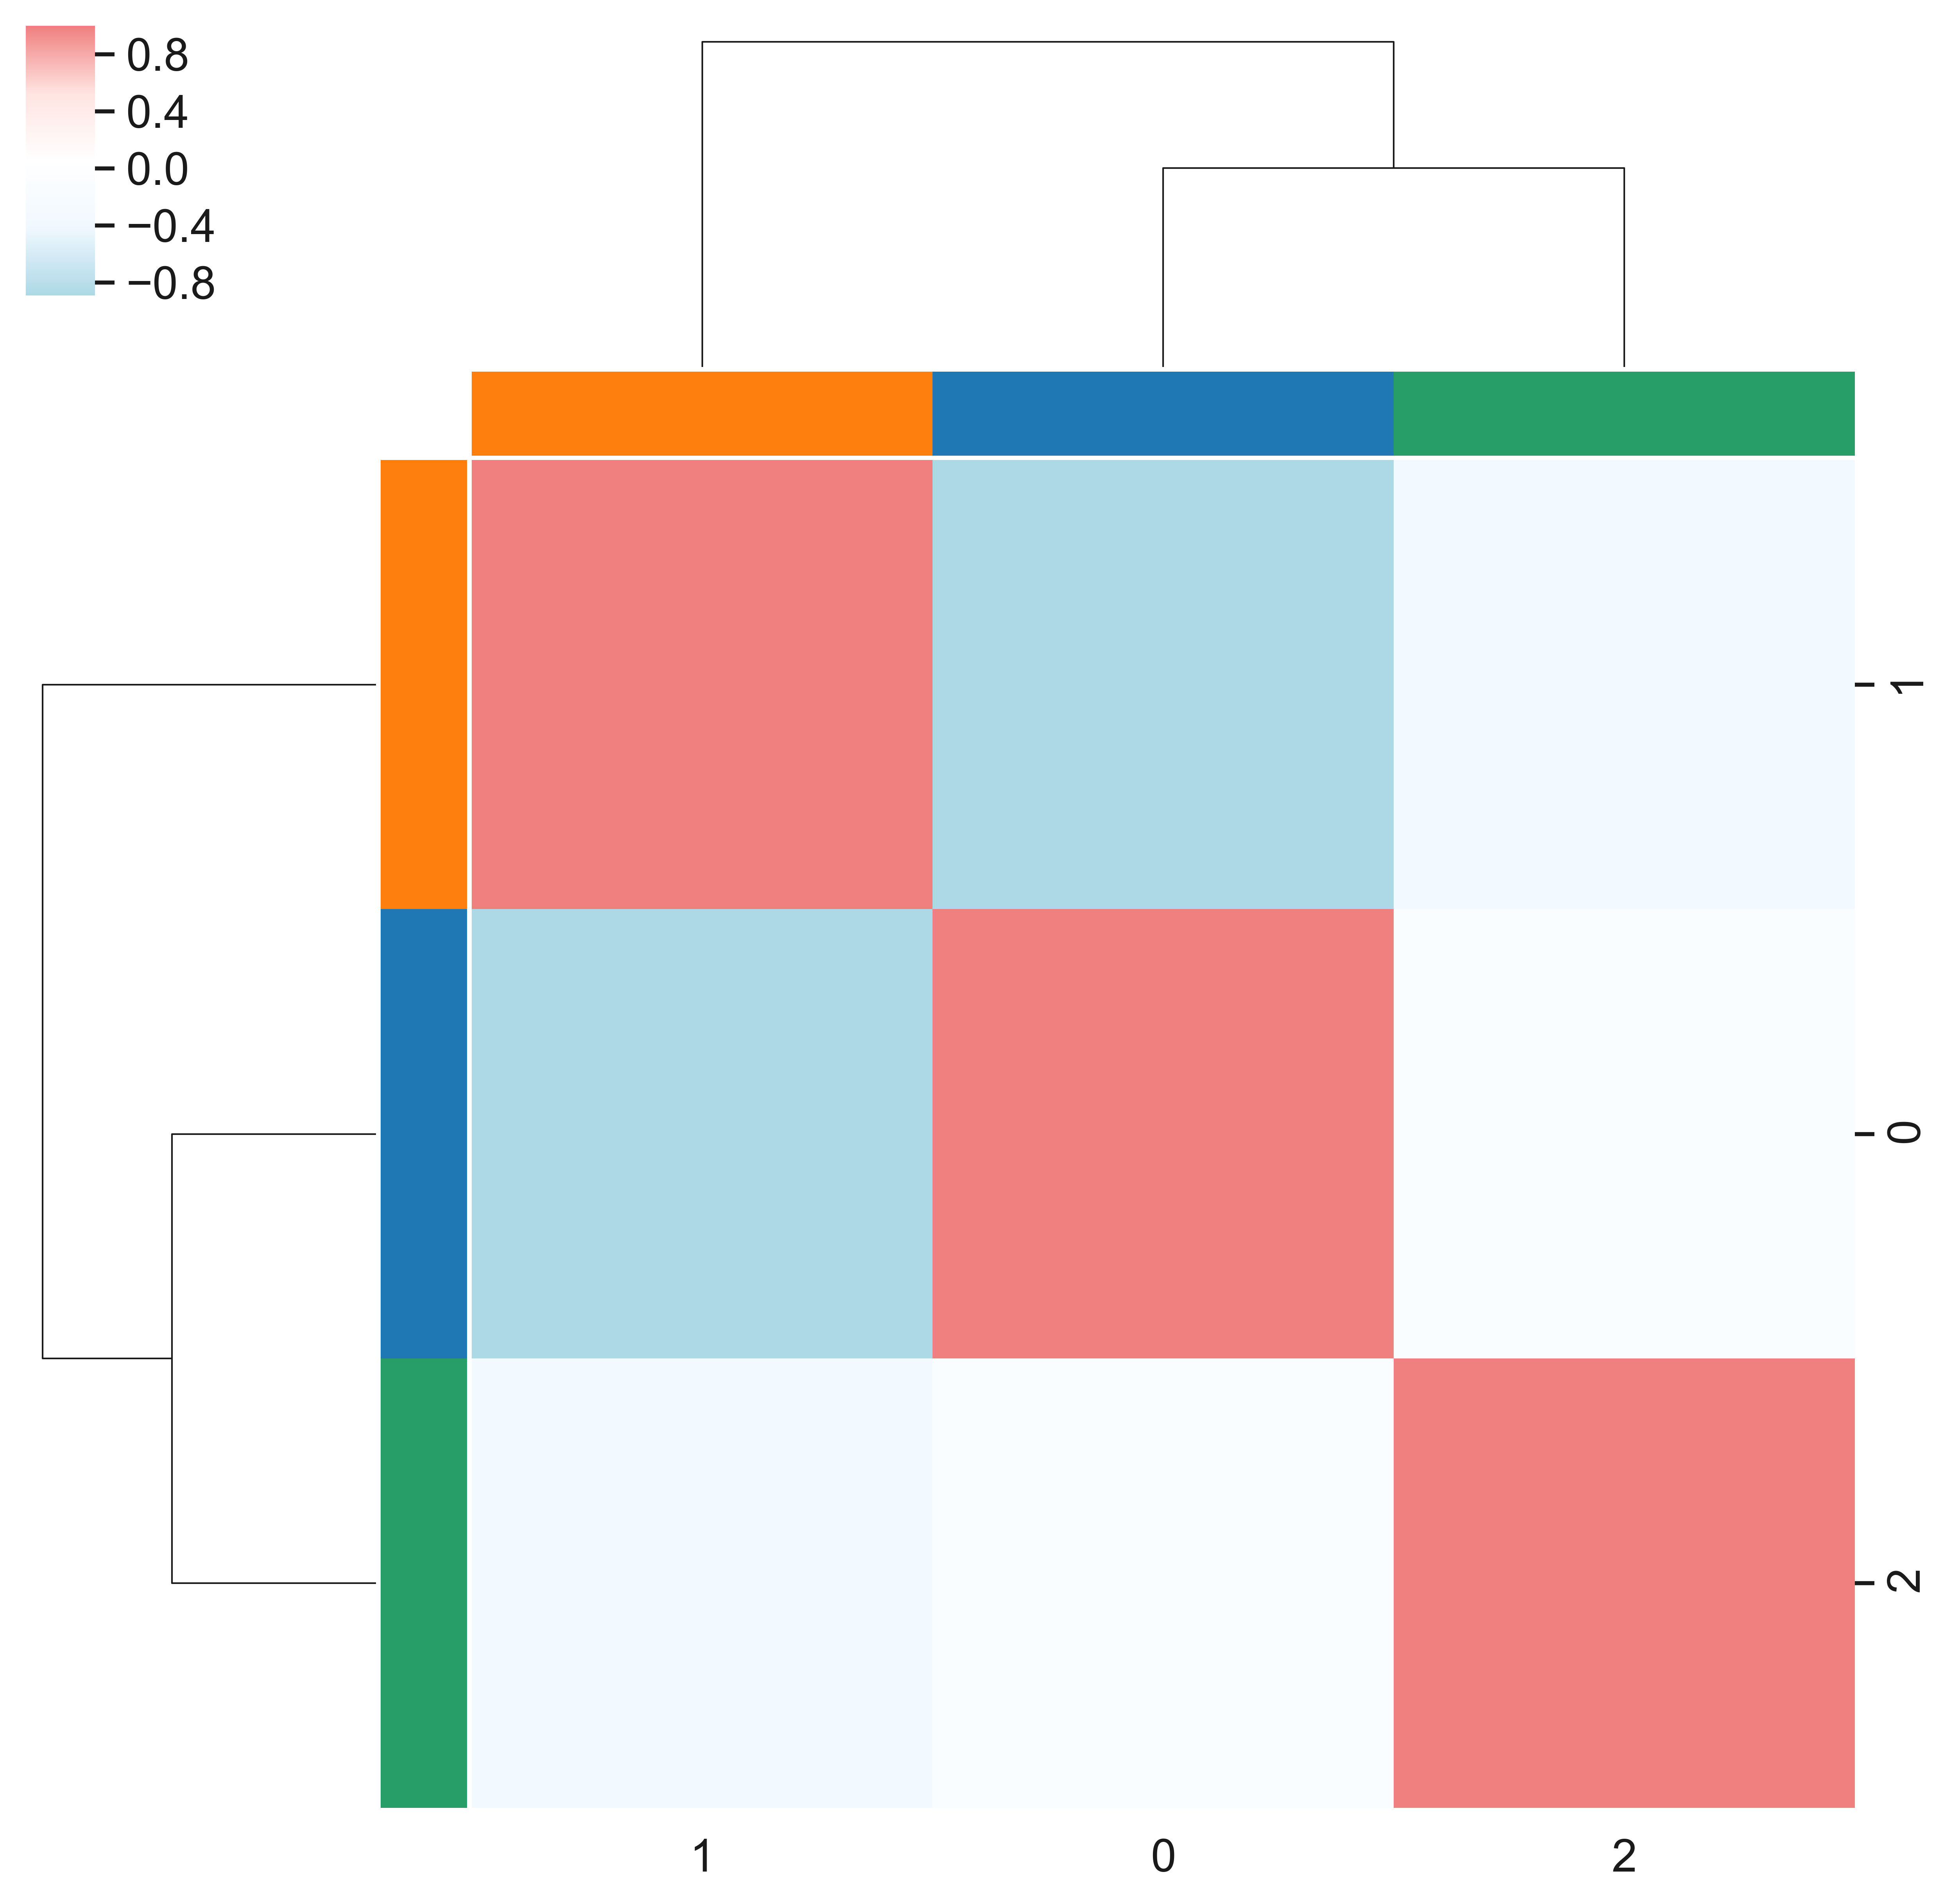

In [273]:
# Plot
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightblue",'aliceblue','white','mistyrose',"lightcoral"]) 
g = sb.clustermap(
adata_subset.uns['dendrogram_louvain_r0.2']['correlation_matrix'],
row_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'], 
col_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'],
yticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
xticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
annot=False,
cmap=cmap,
row_colors=adata_subset.uns['louvain_r0.2_colors'],
col_colors=adata_subset.uns['louvain_r0.2_colors'],
cbar_kws={'label': ''}
                 )
plt.savefig('./figures/correlation_plot.png', bbox_inches='tight')

#### Determine gene expression changes for epithelial lineage genes

##### Lyz2

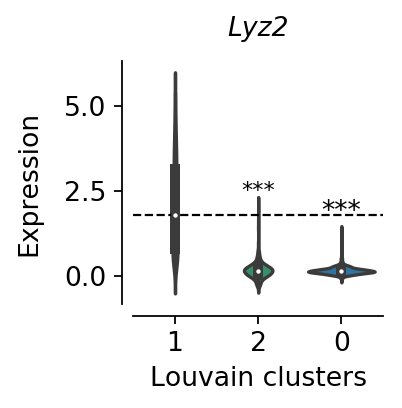

In [10]:
adata_subset.obs['Lyz2']=adata_subset[:, ['Lyz2']].to_df()

# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Lyz2', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results

order=['1','2','0']
palette=['#ff7f0e','#279e68','#1f77b4']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Lyz2', x='louvain_r0.2', data=adata_subset.obs, order=order, palette=palette)
despine(right=True, offset=5)
plt.title('Lyz2', fontsize=12, y=1.05, fontstyle='italic')
plt.ylabel('Expression', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Lyz2'].max() + 2.2, 2.2, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Lyz2'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

adata_subset.obs = adata_subset.obs.drop('Lyz2', axis=1)

### Sftpc

In [11]:
# Add gene expression to adata.obs
adata_subset.obs['Sftpc']=adata_subset[:, ['Sftpc']].to_df()

# Mann Whitney U test 
from scipy.stats import mannwhitneyu

cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
print(mannwhitneyu(cat1['Sftpc'], cat2['Sftpc']))
print(mannwhitneyu(cat1['Sftpc'], cat0['Sftpc']) )


MannwhitneyuResult(statistic=6806.0, pvalue=0.0)
MannwhitneyuResult(statistic=252.0, pvalue=0.0)


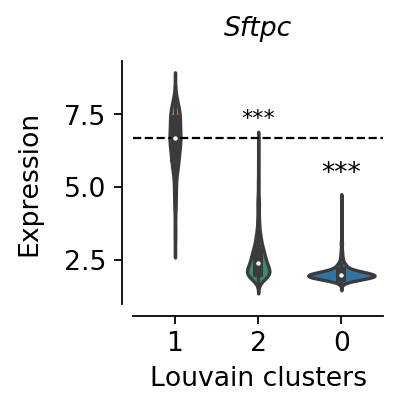

In [12]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sftpc', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi'] = 80
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sftpc', x='louvain_r0.2', data=adata_subset.obs, order=order,
palette=['#ff7f0e','#279e68','#1f77b4'])
despine(right=True, offset=5)
plt.title('Sftpc', fontsize=12, y=1.05, fontstyle='italic')
plt.ylabel('Expression', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sftpc'].max() + 7,7, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sftpc'].max() + 5,5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

# Remove Sftpc from adata_subset.obs
adata_subset.obs = adata_subset.obs.drop(['Sftpc'], axis=1)

### Nkx2-1

In [13]:
# Add gene expression to adata.obs
adata_subset.obs['Nkx2-1']=adata_subset[:, ['Nkx2-1']].to_df()

# Mann Whitney U test 
from scipy.stats import mannwhitneyu

cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
print(mannwhitneyu(cat1['Nkx2-1'], cat2['Nkx2-1']))
print(mannwhitneyu(cat1['Nkx2-1'], cat0['Nkx2-1']) )

MannwhitneyuResult(statistic=31030.0, pvalue=0.0)
MannwhitneyuResult(statistic=9427.0, pvalue=0.0)


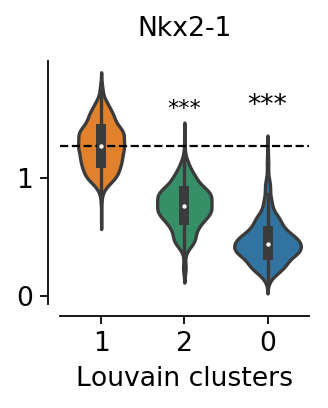

In [15]:
# Find medians
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Nkx2-1', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nkx2-1', x='louvain_r0.2', data=adata_subset.obs, order=order, palette=['#ff7f0e','#279e68','#1f77b4'],
)
despine(right=True, offset=5)
plt.title('Nkx2-1', fontsize=12, y=1.05)
plt.ylabel('', fontsize=12, labelpad=10)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Nkx2-1'].max() + 1.5,1.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Nkx2-1'].max() + 1.5,1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

# Remove Nkx2-1 from adata_subset.obs
adata_subset.obs = adata_subset.obs.drop(['Nkx2-1'], axis=1)

### Differential Expression (DE) Analysis

In [276]:
# Differential expression (DE) and Enrichr analysis

# Identify DE gene using the in-built ScanPy function

# Filtered gene list for TF/TFC identification. I wanted to be stringent
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon', n_genes=1000, use_raw=True)

# Removed the outgroup filter, but kept the log fold change and ingroup filter
sc.tl.filter_rank_genes_groups(adata_subset, 
   min_fold_change = 1, # minimum log fold change   
   min_in_group_fraction = 0.5,  # 50% of cells in the cluster must express the gene
   max_out_group_fraction = 0.5, # No more than 50% of cells outside a cluster can express this genes
   key_added='rank_genes_groups_filtered') # filtered group key

result = adata_subset.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names

# export filtered DE results to excel 
df1=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
df1.to_excel("adata_subset_DE_top1000_filtered.xlsx", sheet_name='Top 1000 filtered')

ranking genes
    finished (0:00:06)
Filtering genes using: min_in_group_fraction: 0.5 min_fold_change: 1, max_out_group_fraction: 0.5


In [562]:
# Plot heatmap
heatmap_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','mistyrose','red']) # color map

ax=sc.pl.rank_genes_groups_heatmap(adata_subset, n_genes=20,cmap=heatmap_cmap,swap_axes=True, use_raw=False, 
key='rank_genes_groups_filtered', vmin=0.2, vmax=1, show_gene_labels=True, figsize=(15,15), show=False)

### Gene Ontology (GO) Enrichment Analysis - Biological Process

In [280]:
# Unfiltered gene list for GO analysis identification. I wanted to be less stringent here
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon',n_genes=1000, use_raw=True)

result = adata_subset.uns['rank_genes_groups']
groups = result['names'].dtype.names

# export DE results to excel 
mouse_DE_df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
mouse_DE_df.to_excel("adata_subset_DE_top1000_unfiltered.xlsx", sheet_name='Top 1000 unfiltered')

# Look for enriched Gene Ontology Biological Process 2018 pathways

%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import gseapy as gp
from gseapy.plot import barplot, dotplot # only needed if you want bar and dot plots

#view available reference libraries
names = gp.get_library_name() # a list of available libraries will appear

# turn columns into lists (filtered data)
C0 = mouse_DE_df['0_n']
C1 = mouse_DE_df['1_n']
C2 = mouse_DE_df['2_n']

# drop NaN: NaNs cause enricher to break
C0=C0.dropna()
C1=C1.dropna()
C2=C2.dropna()

# GO Analysis

Cluster0_GOBio = gp.enrichr(gene_list = C0,
description='Cluster0_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster0_GOBio',
cutoff=0.05
)

Cluster1_GOBio = gp.enrichr(gene_list = C1,
description='Cluster1_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster1_GOBio',
cutoff=0.05
)

Cluster2_GOBio = gp.enrichr(gene_list = C2,
description='Cluster2_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster2_GOBio',
cutoff=0.05
)

# find unique GO terms in clusters 0, 

# filter for statistically significant terms

c0_sig = Cluster0_GOBio.res2d.loc[(Cluster0_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c1_sig = Cluster1_GOBio.res2d.loc[(Cluster1_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c2_sig = Cluster2_GOBio.res2d.loc[(Cluster2_GOBio.res2d['Adjusted P-value'] < 0.05)] 

c0_list = c0_sig['Term'].tolist() 
c1_list = c1_sig['Term'].tolist() 
c2_list = c2_sig['Term'].tolist() 

# look for unique and common terms in C1 and C0

c0_unique_terms = []
c1_unique_terms = []
c2_unique_terms = []
common_terms = []

for i in c0_list:
    if i not in c1_list and i not in c2_list:
        c0_unique_terms.append(i)

for i in c1_list:
    if i not in c0_list and i not in c2_list:
        c1_unique_terms.append(i)
               
for i in c2_list:
    if i not in c0_list and i not in c1_list:
        c2_unique_terms.append(i)   
        
for i in c2_list:
    if i in c0_list and i in c1_list:
        common_terms.append(i) 

ranking genes
    finished (0:00:09)


In [281]:
# Export  unique terms to excel
pd.DataFrame(c0_unique_terms).to_excel("Unique cluster 0 terms.xlsx", sheet_name='C0 unique')
pd.DataFrame(c1_unique_terms).to_excel("Unique cluster 1 terms.xlsx", sheet_name='C1 unique')
pd.DataFrame(c2_unique_terms).to_excel("Unique cluster 2 terms.xlsx", sheet_name='C2 unique')
pd.DataFrame(common_terms).to_excel("Common cluster terms.xlsx", sheet_name='common') 

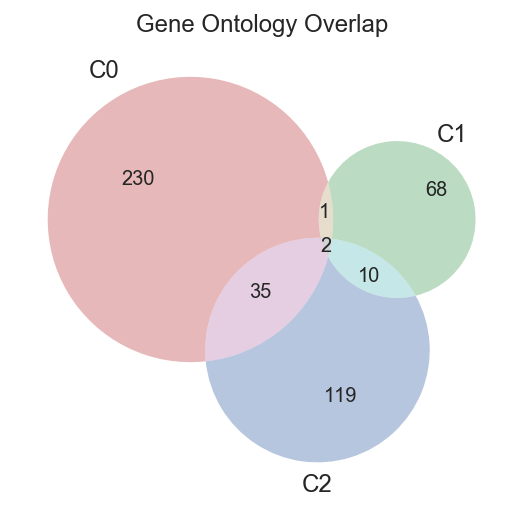

In [282]:
# plot overlap using a venn diagram and check it matches the length of the lists above

from matplotlib_venn import venn3
ax=venn3([set(c0_list), set(c1_list), set(c2_list)],set_labels = ('C0', 'C1','C2'))
plt.title('Gene Ontology Overlap', fontsize=12)

## Calculate signature scores

In [283]:
# Calculating z-scores for single cells

adata_subset.obs['index1'] = adata_subset.obs.index # cell barcodes column

TTRUST_sox9 = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Sox9 targets TRRUST', header=0)
TTRUST_rela = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Rela targets NFKB TRRUST', header=0)
bild_kras_list = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Bild et al. 2006 (Kras genes)', header=0)
PLDB = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='AT2 marker genes (PanglaoDB)', header=0)
GO_ed_input = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='GO 0009790 Embryo Development', header=0)

# sox9 list
TTRUST_activation_sox9 = TTRUST_sox9.loc[(TTRUST_sox9['Type'] == 'Activation')] 
TTRUST_activation_sox9_list = TTRUST_activation_sox9['Target'].tolist() 
TTRUST_activation_sox9_list = [x for x in TTRUST_activation_sox9_list if x in adata.var_names] 

# rela (nfkb) list
TTRUST_activation_rela = TTRUST_rela.loc[(TTRUST_rela['Type'] == 'Activation')] 
TTRUST_activation_rela_list = TTRUST_activation_rela['Target'].tolist() 
TTRUST_activation_rela_list = [x for x in TTRUST_activation_rela_list if x in adata.var_names] 

# kras list
bild_kras_list = bild_kras_list['GeneSymbol'].tolist() 
bild_kras_list = [x.lower() for x in bild_kras_list] 
bild_kras_list = [x.capitalize() for x in bild_kras_list]
bild_kras_list_final = [x for x in bild_kras_list if x in adata.var_names] 

# AT2 signature
PLDB_AT2 = PLDB.loc[(PLDB['cell type'] == 'Pulmonary alveolar type II cells') & (PLDB['species'] != 'Hs')] 
PLDB_AT2_list = PLDB_AT2['official gene symbol'].tolist() 
PLDB_AT2_list = [x.lower() for x in PLDB_AT2_list]
PLDB_AT2_list = [x.capitalize() for x in PLDB_AT2_list] 
PLDB_AT2_list_final = [x for x in PLDB_AT2_list if x in adata.var_names] 

# Development signature
GO_ed_set = set(GO_ed_input['Symbol'].tolist())
GO_ed_2 = list(dict.fromkeys(GO_ed_set)) 
GO_ed_list = [x for x in GO_ed_2 if x in adata_subset.var_names]

# Calculating z-scores for single cells

# Modified from: https://github.com/theislab/scanpy/issues/290

# create the marker dict 
marker_genes = dict()
marker_genes['Proliferation signature'] = ['Pbk','Birc5','Mki67','Ube2c','Top2a','Tk1','Aurkb','Cdkn3','Cenpf','Cdk1','Zwint']
marker_genes['Sox9_score'] = TTRUST_activation_sox9_list
marker_genes['Nfkb activation signature'] = TTRUST_activation_rela_list
marker_genes['Kras activation signature'] = bild_kras_list_final
marker_genes['AT2 signature'] = PLDB_AT2_list_final
marker_genes['Development signature'] = GO_ed_list

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        
    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
            
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) # try changing this to anndata_raw as a separate function

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()

# save signatures
adata_subset.obs['Proliferation signature'] = df_transposed['Proliferation signature']
adata_subset.obs['Sox9_score'] = df_transposed['Sox9_score']
adata_subset.obs['Nfkb activation signature'] = df_transposed['Nfkb activation signature']
adata_subset.obs['Kras activation signature'] = df_transposed['Kras activation signature']
adata_subset.obs['AT2 signature'] = df_transposed['AT2 signature']
adata_subset.obs['Development signature'] = df_transposed['Development signature']

# save anndata
adata_subset.write(subset_results_file)

#### Sxo9 expression and signature for genes activated by Sox9

#### Genes activated by Sox9

In [18]:
# Mann-Whitney U test 
from scipy.stats import mannwhitneyu

cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

print(mannwhitneyu(cat1['Sox9 targets'], cat2['Sox9 targets'])) 
print(mannwhitneyu(cat1['Sox9 targets'], cat0['Sox9 targets']))

MannwhitneyuResult(statistic=721727.0, pvalue=0.43330723182243364)
MannwhitneyuResult(statistic=796240.0, pvalue=8.940037120179113e-76)


Text(2, 1.5, '***')

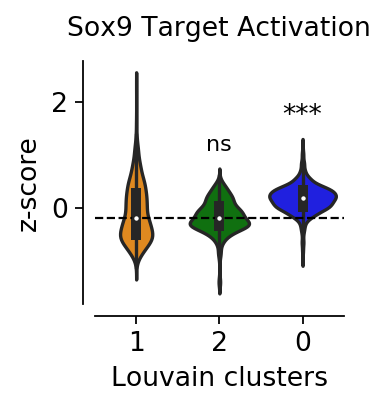

In [19]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sox9 targets', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results

dpi=300
order=['1','2','0']

rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9 targets', x='louvain_r0.2', data=adata_subset.obs, order=order,
                   palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Sox9 Target Activation', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sox9 targets'].max() + 1, 1, 'k'
plt.text(x1, h, "ns", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9 targets'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)


### Sox9

In [25]:
adata_subset.obs['Sox9']=adata_subset[:, ['Sox9']].to_df()

# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat1['Sox9'], cat2['Sox9'])) 
print(mannwhitneyu(cat1['Sox9'], cat0['Sox9'])) 

MannwhitneyuResult(statistic=284872.0, pvalue=7.434361733541274e-145)
MannwhitneyuResult(statistic=74864.0, pvalue=0.0)


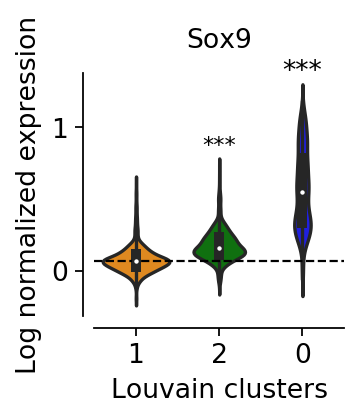

In [26]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Sox9', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'], palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Sox9', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sox9'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Sox9'].max() + 1.3, 1.3, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

# Remove gene from adata_subset.obs
adata_subset.obs = adata_subset.obs.drop(['Sox9'], axis=1)


###  Hmga2

In [30]:
adata_subset.obs['Hmga2']=adata_subset[:, ['Hmga2']].to_df()

# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat1['Hmga2'], cat2['Hmga2'])) 
print(mannwhitneyu(cat1['Hmga2'], cat0['Hmga2'])) 

MannwhitneyuResult(statistic=177174.0, pvalue=3.3669169777698502e-223)
MannwhitneyuResult(statistic=35548.0, pvalue=0.0)


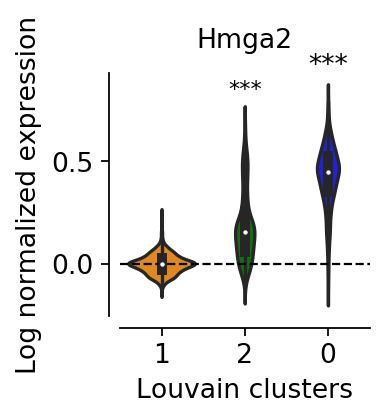

In [31]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Hmga2', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Hmga2', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'],
    palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Hmga2', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Hmga2'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Hmga2'].max() + 0.9, 0.9, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

# Remove gene from adata_subset.obs
adata_subset.obs = adata_subset.obs.drop(['Hmga2'], axis=1)


### Proliferation signature

In [34]:
# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat1['Proliferation'], cat2['Proliferation'])) 
print(mannwhitneyu(cat1['Proliferation'], cat0['Proliferation'])) 

MannwhitneyuResult(statistic=534471.0, pvalue=8.797177966515476e-29)
MannwhitneyuResult(statistic=1211727.0, pvalue=0.005988712235375603)


Text(2, 1.5, '**')

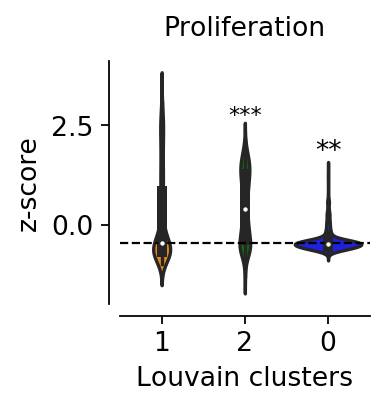

In [36]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Proliferation', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=80
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Proliferation', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'] , palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Proliferation', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Proliferation'].max() + 2.5, 2.5, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Proliferation'].max() + 1.5, 1.5, 'k'
plt.text(x2, h, "**", ha='center', va='bottom', color=col, fontsize=12)

### Genes activated by Nfkb

In [38]:
# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat1['Nfkb targets'], cat2['Nfkb targets'])) 
print(mannwhitneyu(cat1['Nfkb targets'], cat0['Nfkb targets'])) 

MannwhitneyuResult(statistic=609024.0, pvalue=8.52057715192317e-12)
MannwhitneyuResult(statistic=728098.0, pvalue=4.39090524217246e-98)


Text(2, 1.9, '***')

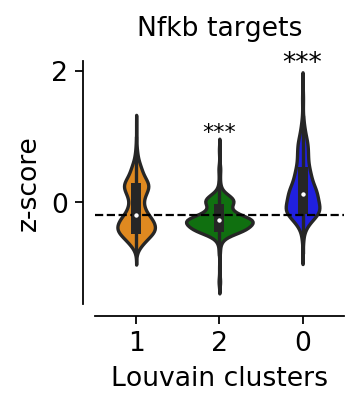

In [39]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Nfkb targets', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=80
with axes_style({'axes.grid': False}):
  ax = sb.violinplot(y='Nfkb targets', x='louvain_r0.2', data=adata_subset.obs, order=['1','2','0'], 
  palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Nfkb targets', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Nfkb targets'].max() + 0.9, 0.9, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Nfkb targets'].max() + 1.9, 1.9, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)

### Kras activation signature

In [41]:
# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
print(mannwhitneyu(cat1['Kras activation'], cat2['Kras activation'])) 
print(mannwhitneyu(cat1['Kras activation'], cat0['Kras activation'])) 

MannwhitneyuResult(statistic=405507.0, pvalue=2.42953184179876e-77)
MannwhitneyuResult(statistic=487067.0, pvalue=1.4697095770913765e-200)


Text(2, 1.4, '***')

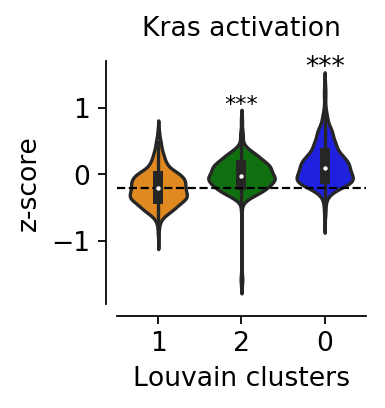

In [42]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='Kras activation', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=80
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Kras activation', x='louvain_r0.2', 
 data=adata_subset.obs, order=['1','2','0'], palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('Kras activation', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Kras activation'].max() + 0.9, 0.9, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['Kras activation'].max() + 1.4, 1.4, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)


### AT2 signature

In [44]:
# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu

# Perform a Mann Whitney U test 
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]
cat2 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '2')]

print(mannwhitneyu(cat1['AT2 signature'], cat2['AT2 signature']))
print(mannwhitneyu(cat1['AT2 signature'], cat0['AT2 signature']))

MannwhitneyuResult(statistic=16437.0, pvalue=0.0)
MannwhitneyuResult(statistic=802.0, pvalue=0.0)


Text(2, 0.3, '***')

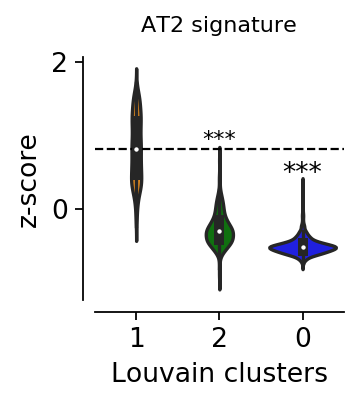

In [46]:
df=adata_subset.obs
df_1 = pd.pivot_table(df, values='AT2 signature', index='index1', columns='louvain_r0.2')
value_df = pd.DataFrame(df_1.median())

# Plot
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=80
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='AT2 signature', x='louvain_r0.2', data=adata_subset.obs, 
  order=['1','2','0'], palette=['darkorange','green','blue'])
despine(right=True, offset=5)
plt.title('AT2 signature', fontsize=10, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(value_df[0].iloc[1], color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['AT2 signature'].max() + 0.8, 0.8, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

# statistical annotation
x2 = 2   
y, h, col = adata_subset.obs['AT2 signature'].max() + 0.3, 0.3, 'k'
plt.text(x2, h, "***", ha='center', va='bottom', color=col, fontsize=12)